In [50]:
from sgp4.api import Satrec, WGS72
from sgp4.api import jday
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [72]:
#import the test tle file
file_path = "test_tle.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

In [73]:
# read test tle file and organize into name, line1 and line2
table = []

for i in range(0, len(lines), 3):
    name = lines[i].strip()
    line_1 = lines[i+1].strip()
    line_2 = lines[i+2].strip()

    table.append([name, line_1, line_2])

columns = ['Name', 'Line 1', 'Line 2']

df = pd.DataFrame(table, columns=columns)


In [74]:
df

,Name,Line 1,Line 2
0,CALSPHERE 1,1 00900U 64063C 25009.89296725 .00000966 0...,2 00900 90.2090 59.8649 0027333 79.0263 331...
1,CALSPHERE 2,1 00902U 64063E 25009.16760729 .00000050 0...,2 00902 90.2243 63.6007 0016938 312.8486 113...
2,LCS 1,1 01361U 65034C 25009.29837725 .00000014 0...,2 01361 32.1465 340.9248 0010070 64.3760 295...
3,TEMPSAT 1,1 01512U 65065E 25009.79003184 .00000068 0...,2 01512 89.9638 213.3307 0067898 278.7099 92...
4,CALSPHERE 4A,1 01520U 65065H 25009.81288413 .00000144 0...,2 01520 89.9354 126.8379 0070779 139.8391 341...
5,OPS 5712 (P/L 160),1 02826U 67053A 25009.87494395 .00009274 0...,2 02826 69.9208 230.4414 0000711 229.0460 131...
6,LES-5,1 02866U 67066E 25009.18076066 -.00000055 0...,2 02866 1.4525 118.8942 0057217 179.2418 251...
7,SURCAL 159,1 02872U 67053F 25010.12574172 .00000180 0...,2 02872 69.9744 46.9863 0003449 67.3364 292...
8,OPS 5712 (P/L 153),1 02874U 67053H 25009.13733075 .00000140 0...,2 02874 69.9731 158.4577 0006837 180.5323 179...
9,SURCAL 150B,1 02909U 67053J 25010.16793315 .00047005 0...,2 02909 69.9303 154.0331 0002925 341.4713 18...


In [75]:
results = []

# get all the positions and velocities of the satellites
for index, row in df.iterrows():
    name = row['Name']
    line1 = row['Line 1']
    line2 = row['Line 2']

    satellite = Satrec.twoline2rv(line1, line2)

    # Date of when we want to check the position of the satallite, can also loop it to see its trajectory
    year = 2025
    month = 1
    hour = 0
    minute = 0
    second = 0

    # Loop over every day of one month (can change to hours, and can do it over much longer time)
    # Convert the date into julian date
    for day in range(0,31):
        jd, fr = jday(year, month, day, hour, minute, second)

        # Measure the satellite position (r) and velocity (r) at the given date
        e, r, v = satellite.sgp4(jd, fr)
        
        if e == 0:
            # Add a row to the results list
            results.append({
                "Name": name,
                "Time": f"{year}-{month:02d}-{day:02d} {hour:02d}:{minute:02d}:{second:02d}",
                "Position (km)": list(r),
                "Velocity (km/s)": list(v)
            })
        else:
            print(f"Error propagating {name}: Error code {e}")

columns = ['Name', 'Time', 'Position(km)', 'Velocity(km/s)']
# Convert the results into a DataFrame
rv_df = pd.DataFrame(results)

# Flatten the position and velocity columns to separate components
rv_df[['Position X (km)', 'Position Y (km)', 'Position Z (km)']] = pd.DataFrame(rv_df['Position (km)'].tolist(), index=rv_df.index)
rv_df[['Velocity X (km/s)', 'Velocity Y (km/s)', 'Velocity Z (km/s)']] = pd.DataFrame(rv_df['Velocity (km/s)'].tolist(), index=rv_df.index)

# Drop the original 'Position (km)' and 'Velocity (km/s)' columns
rv_df = rv_df.drop(columns=['Position (km)', 'Velocity (km/s)'])


In [76]:
rv_df

,Name,Time,Position X (km),Position Y (km),Position Z (km),Velocity X (km/s),Velocity Y (km/s),Velocity Z (km/s)
0,CALSPHERE 1,2025-01-00 00:00:00,2691.151739,4558.832980,5091.613434,-2.575217,-4.435826,5.294367
1,CALSPHERE 1,2025-01-01 00:00:00,2553.024109,4402.226740,-5347.381458,2.694904,4.569515,5.064402
2,CALSPHERE 1,2025-01-02 00:00:00,-2704.464317,-4589.613610,-5099.083818,2.538253,4.380571,-5.317602
3,CALSPHERE 1,2025-01-03 00:00:00,-2516.624283,-4347.651841,5346.646406,-2.734912,-4.646283,-5.039115
4,CALSPHERE 1,2025-01-04 00:00:00,2755.893865,4687.067634,4933.887867,-2.489850,-4.306258,5.444475
...,...,...,...,...,...,...,...,...
367,RIGIDSPHERE 2 (LCS 4),2025-01-26 00:00:00,401.870103,-1290.954194,6967.066105,3.701966,-6.386723,-1.404241
368,RIGIDSPHERE 2 (LCS 4),2025-01-27 00:00:00,2427.188884,-3842.771690,-5553.821453,-2.640458,5.091937,-4.730247
369,RIGIDSPHERE 2 (LCS 4),2025-01-28 00:00:00,-3475.201776,6261.446425,-184.465980,-0.338312,-0.027076,7.446313
370,RIGIDSPHERE 2 (LCS 4),2025-01-29 00:00:00,1950.812243,-4021.819962,5520.085506,2.995210,-5.040860,-4.695095


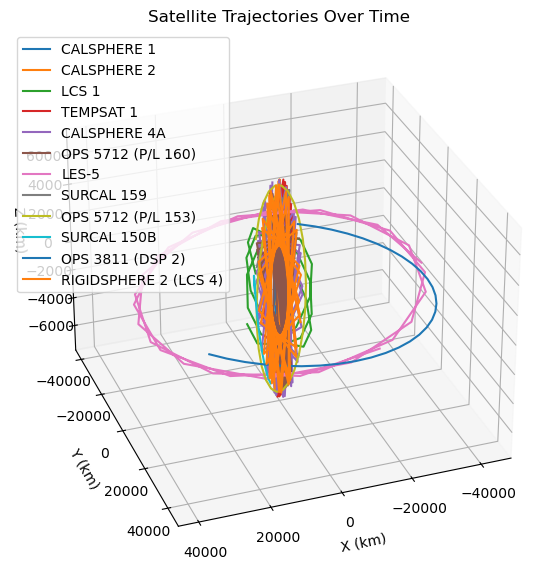

In [81]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Loop over each satellite and plot its trajectory over multiple days
for name in rv_df['Name'].unique(): 
    satellite_data = rv_df[rv_df['Name'] == name]
    
    # Get all positions over time (all rows for that satellite)
    x_pos = satellite_data['Position X (km)']
    y_pos = satellite_data['Position Y (km)']
    z_pos = satellite_data['Position Z (km)']
    
    # Plot the satellite's trajectory as a line
    ax.plot(x_pos, y_pos, z_pos, label=name)

# Customize the plot
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('Satellite Trajectories Over Time')


# Adjust the view angle: elevation and azimuth
ax.view_init(elev=30, azim=70) 
ax.legend()
